In [41]:
import rich

import pandas
import seaborn

from matplotlib import pyplot

In [42]:
DATA_PATH: str = "../../data/raw/twitter"
REPORT_PATH: str = "../../reports/preliminary"

In [ ]:
datasets = {
    ("German", "Posts"): pandas.read_csv(f"{DATA_PATH}.german/GermanyMdBTweets_2023.csv", index_col=[0]),
    ("German", "Replies"): pandas.read_csv(f"{DATA_PATH}.german/GermanyReplies2023.csv", index_col=[0]),
    ("English", "Posts"): pandas.read_csv(f"{DATA_PATH}.english/USCongressTweets_2023.csv"),
    ("English", "Replies"): pandas.concat(
        [
            pandas.read_csv(f"{DATA_PATH}.english/{split}.csv")
            for split in [
                "USReplies_2023_1", "USReplies_2023_2", "USReplies_2023_July",
                "USReplies_2023_August_I", "USReplies_2023_August_II"
            ]
        ]
)
}

/tmp/ipykernel_3539795/645406185.py:7: DtypeWarning: Columns (2,3,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  pandas.read_csv(f"{DATA_PATH}/raw/twitter.english/{split}.csv")


In [15]:
rich.print({
    label: len(df)
    for label, df in datasets.items()
})

{
    ('German', 'Posts'): 154834,
    ('German', 'Replies'): 3226277,
    ('English', 'Posts'): 932755,
    ('English', 'Replies'): 17803216
}

In [18]:
for df in datasets.values():
    rich.print(df.columns)

Index(['Unnamed: 0', 'id', 'author_id', 'conversation_id', 'text',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.impression_count', 'public_metrics.bookmark_count',
       'created_at', 'username'],
      dtype='object')

Index(['Unnamed: 0', 'id', 'author_id', 'conversation_id', 'text',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'public_metrics.bookmark_count', 'public_metrics.impression_count',
       'created_at', 'username', 'in_reply_to_user_id'],
      dtype='object')

Index(['text', 'id', 'created_at', 'screen_name', 'author_id',
       'retweeted_user_ID', 'collected_at', 'reply_to_id', 'reply_to_user',
       'expandedURL'],
      dtype='object')

Index(['text', 'id', 'created_at', 'screen_name', 'author_id',
       'retweeted_user_ID', 'collected_at', 'reply_to_id', 'reply_to_user',
       'expandedURL'],
      dtype='object')

In [17]:
for label in [
    ("English", "Posts"),
    ("English", "Replies")
]:
    datasets[label] = datasets[label].rename(columns={"full_text": "text", "tweet_id": "id", "original_user_id": "author_id"})

In [45]:
sampled_concated_dataset = (
    pandas.concat(
        [
            df[["author_id", "text"]].sample(100_000)
            for df in datasets.values()
        ],
        keys=datasets.keys()
    )
    .reset_index()
    .rename(columns={"level_0": "lang", "level_1": "subset", "level_2": "idx"})
)
sampled_concated_dataset

,lang,subset,idx,author_id,text
0,German,Posts,37493,1.524342e+18,"Moin, guter Tag einen Baum zu pflanzen. Mammut..."
1,German,Posts,41726,1.633766e+07,@JuergenZimmerer kaufe ein R und will lösen.
2,German,Posts,27384,1.425265e+09,@dgem_ev @DDG_Tweets @BMG_Bund @dgimev @dgho_e...
3,German,Posts,50245,1.775277e+07,Genau dieses jahrzehntelange negative Framing ...
4,German,Posts,150076,9.614650e+07,RT @AhmadMansour__: Beim Jewrovision 2023 heut...
...,...,...,...,...,...
399995,English,Replies,235631,7.974016e+17,"Sure, the fake news media PR machine would pre..."
399996,English,Replies,1488815,1.177786e+18,@jsrafuse_art @HannahThibedeau 🤣🤣🤣
399997,English,Replies,579977,2.749127e+08,We think the @forduk E-Transit is the best new...
399998,English,Replies,88102,9.365495e+07,@JamesGunn @MarvelStudios @Guardians YES


In [68]:
(
    sampled_concated_dataset
    .groupby(["lang", "subset"])
    ["author_id"]
    .value_counts()
    .reset_index()
    .groupby(["lang", "subset"])
    ["count"]
    .describe()
    .drop(columns=["count"])
    #.to_latex(float_format="%.2f")
)

mean         std  min   25%    50%    75%     max
lang    subset                                                          
English Posts     97.983437   23.904727  3.0  94.0  104.0  112.0   138.0
        Replies    2.703588    2.612793  1.0   1.0    2.0    3.0    31.0
German  Posts    145.560408  236.569584  1.0  18.5   72.0  163.0  2111.0
        Replies    2.245980    3.180204  1.0   1.0    1.0    2.0   147.0

In [ ]:
(
    sampled_concated_dataset
    .pipe(lambda _df: (
        _df
        .assign(text=_df["text"].str.replace('http\S+|www.\S+', '', case=False))
        .assign(text=_df["text"].str.replace('@\S+', '', case=False))
        .assign(text=_df["text"].str.replace('^RT', '', case=True))
        .assign(text_length=_df["text"].str.len())
    ))
    .groupby(["lang", "subset"])
    ["text_length"]
    .describe()
    .drop(columns=["count"])
    #.to_latex(float_format="%.2f")
)

mean        std  min    25%    50%    75%    max
lang    subset                                                        
English Posts    193.42648  84.130477  1.0  127.0  208.0  271.0  684.0
        Replies  140.24802  95.999434  1.0   59.0  116.0  221.0  982.0
German  Posts    164.37194  78.835715  1.0  125.0  140.0  235.0  885.0
        Replies  135.27058  86.775753  4.0   62.0  112.0  199.0  616.0

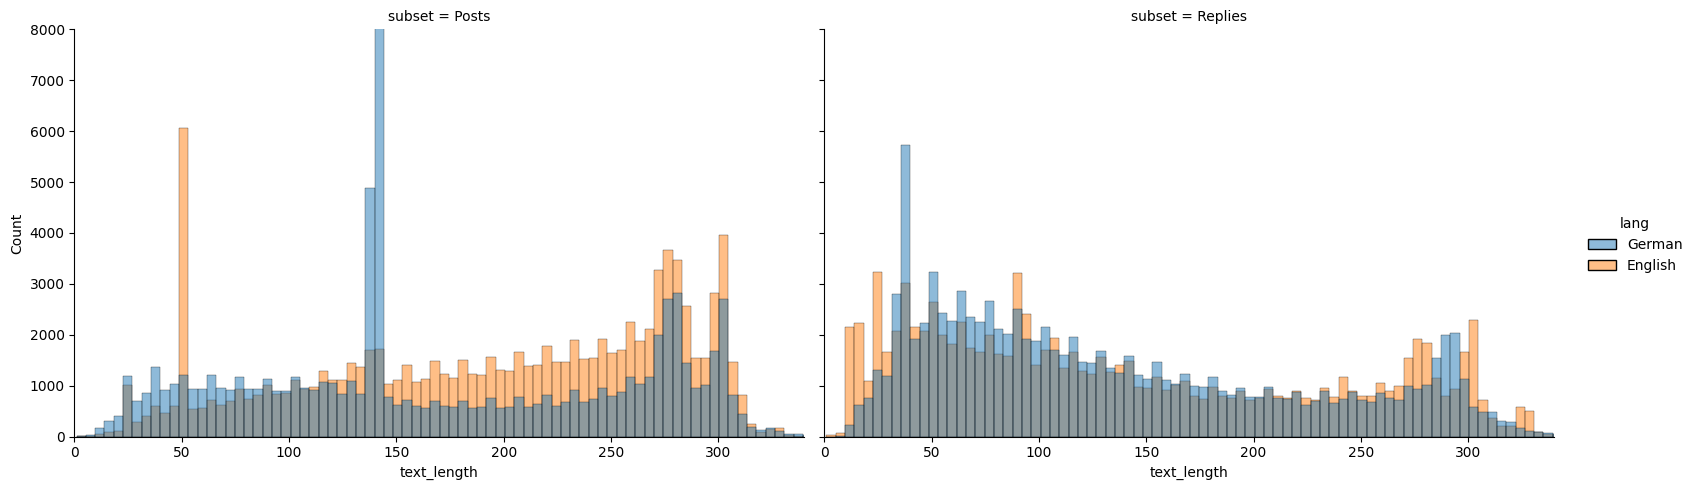

In [43]:
(
    seaborn.displot(
        data=(
            sampled_concated_dataset
            .pipe(lambda _df: (
                _df
                .assign(text=_df["text"].str.replace('http\S+|www.\S+', '', case=False))
                .assign(text=_df["text"].str.replace('@\S+', '', case=False))
                .assign(text_length=_df["text"].str.len())
            ))
        ),
        x="text_length",
        col="subset",
        hue="lang",
        aspect=1.6
    )
    .set(
        xlim=(0, 340), 
        ylim=(0, 8_000)
    )
    .savefig(f"{REPORT_PATH}/dist.len_text.pdf")
)


In [105]:
(
    sampled_concated_dataset
    .pipe(lambda _df: _df.assign(has_url=_df["text"].str.contains("https://")))
    .groupby(["lang", "subset"])
    ["has_url"]
    .value_counts(normalize=True)
    .reset_index(level=2)
    .pipe(lambda _df: _df[_df["has_url"]])
    ["proportion"]
    .to_frame()
    .T
)

lang        English           German        
subset        Posts Replies    Posts Replies
proportion  0.69522  0.5634  0.34346  0.1827